In [85]:
#First import stuff

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from kural_core.models import *
from kural_core.data_processing import *

PATH = 'E:\\DicomData\\LUNG1\\NSCLC-Radiomics\\'

# Stuff for dicom data
import os
import pydicom
from pydicom.data import get_testdata_files
import nrrd


from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage.draw import polygon

In [58]:
#Include some function defs that might be useful

#Function to load and sort a set of slices
def loadScan(folder):
    slices = [pydicom.dcmread(folder+filename) for filename in os.listdir(folder)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    return slices

#Function to load a contour, contours dont need sorting.
def loadContour(folder):
    con = [pydicom.dcmread(folder+filename) for filename in os.listdir(folder)]
    return con

#Function to plot a sub set of the slices in a stack
def plotSlices(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[2*cols,2*rows])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
        ax[int(i/cols),int(i % cols)].imshow(stack[ind].pixel_array, cmap=plt.cm.bone)
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()
    
#Function to plot a sub set of slices if our stack is already pixel maps.
def plotPixelStack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[2*cols,2*rows])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
        ax[int(i/cols),int(i % cols)].imshow(stack[ind], cmap=plt.cm.bone)
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()
    


In [3]:
#Next import all the data/ a subset of the data


patients = [p for p in os.listdir(PATH)]

#(dont actually call this.  it prints like a million lines.)
#for p in patients:
#    print(p)
#    for s in os.listdir(PATH+p+"\\"):
#        print("  " + s)
#        dir2 = [d for d in os.listdir(PATH+p+"\\"+s+"\\")]
#        if len(dir2) > 1:
#            #We need to check which folder has the slices vs the contours.  There is a bunch of slices, but 1 contour.
#            if (len(os.listdir(PATH+p+"\\"+s+"\\"+dir2[1]))) == 1:
#                print("    " + dir2[1])
#                for files2 in os.listdir(PATH+p+"\\"+s+"\\"+dir2[1]):
#                    #These are the contours
#                    print("      Contours: " + files1)
#                print("    " + dir2[0])
#                for files1 in os.listdir(PATH+p+"\\"+s+"\\"+dir2[0]):
#                    #These are the slices
#                    print("      Slices: " + files1)
#            else:
#                print("    " + dir2[0])
#                for files2 in os.listdir(PATH+p+"\\"+s+"\\"+dir2[0]):
#                    #These are the contours
#                    print("      Contours: " + files1)
#                print("    " + dir2[1])
#                for files1 in os.listdir(PATH+p+"\\"+s+"\\"+dir2[1]):
#                    #These are the slices
#                    print("      Slices: " + files1)
#        else: 
#            print("    " + dir2[0])
#            for files1 in os.listdir(PATH+p+"\\"+s+"\\"+dir2[0]):
#                #These are the slices
#                print("      Slices: " + files1)


In [60]:
# Clearly, listing all those files shows thats way way too many to load.  
# lets load every 80 patients for now, and only load the slices. (maybe take a random sample latter)
#
# data = [[[list of slices],[contour]]

data = []

for p in patients[0::80]:
    print(p)
    for s in os.listdir(PATH+p+"\\"):
        dir2 = [d for d in os.listdir(PATH+p+"\\"+s+"\\")]        
        print("  " + s)
        folder = ""
        folderC = ""
        if len(dir2) > 1:
            #We need to check which folder has the slices vs the contours.  There is a bunch of slices, but 1 contour.
            if (len(os.listdir(PATH+p+"\\"+s+"\\"+dir2[1]))) == 1:
                print("    " + dir2[0])
                print("    " + dir2[1])
                folder = PATH+p+"\\"+s+"\\"+dir2[0]+"\\"
                folderC = PATH+p+"\\"+s+"\\"+dir2[1]+"\\"
            else:
                print("    " + dir2[1])
                print("    " + dir2[0])
                folder = PATH+p+"\\"+s+"\\"+dir2[1]+"\\"
                folderC = PATH+p+"\\"+s+"\\"+dir2[0]+"\\"
            contour = loadContour(folderC)
        else: 
            print("    " + dir2[0])
            folder = PATH+p+"\\"+s+"\\"+dir2[0]+"\\"
            contour = []
        slices = loadScan(folder)
        data.append([slices,contour])


LUNG1-001
  09-18-2008-StudyID-69331
    0-82046
    0-95085
LUNG1-081
  12-25-2005-StudyID-34399
    1-56270
    1-31295
LUNG1-161
  01-25-2007-StudyID-99431
    0-13474
    0-02659
LUNG1-241
  05-02-2008-StudyID-66003
    0-04303
    0-21735
LUNG1-321
  12-24-2008-StudyID-98086
    0-57753
    0-40997
LUNG1-401
  05-21-2010-21105
    0-81445


LUNG1-001


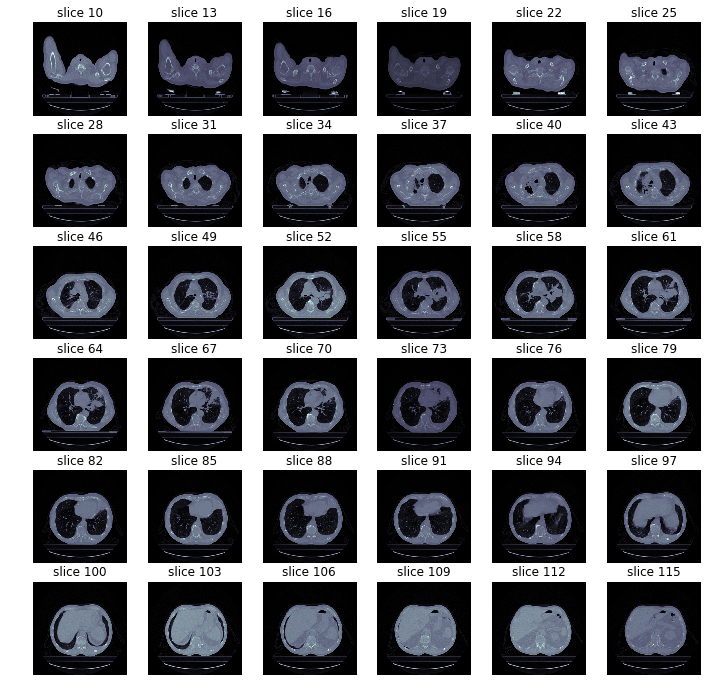

LUNG1-081


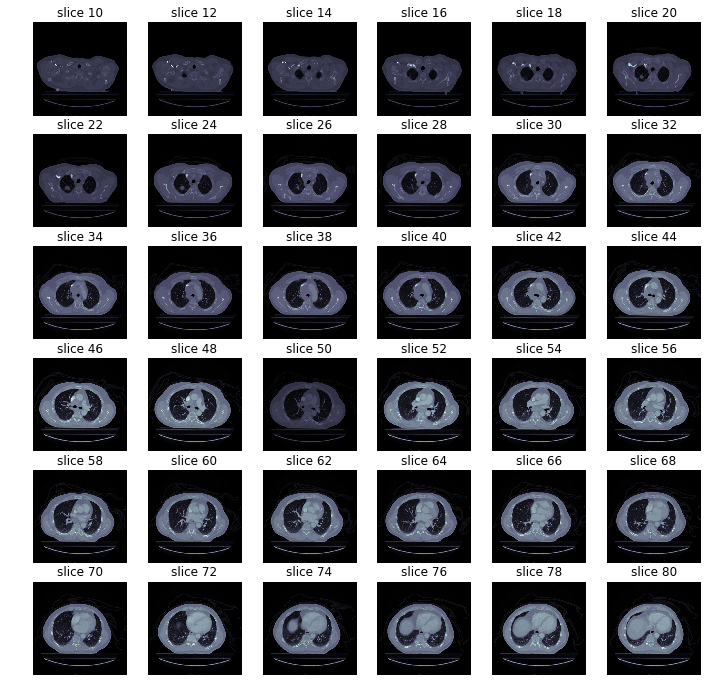

LUNG1-161


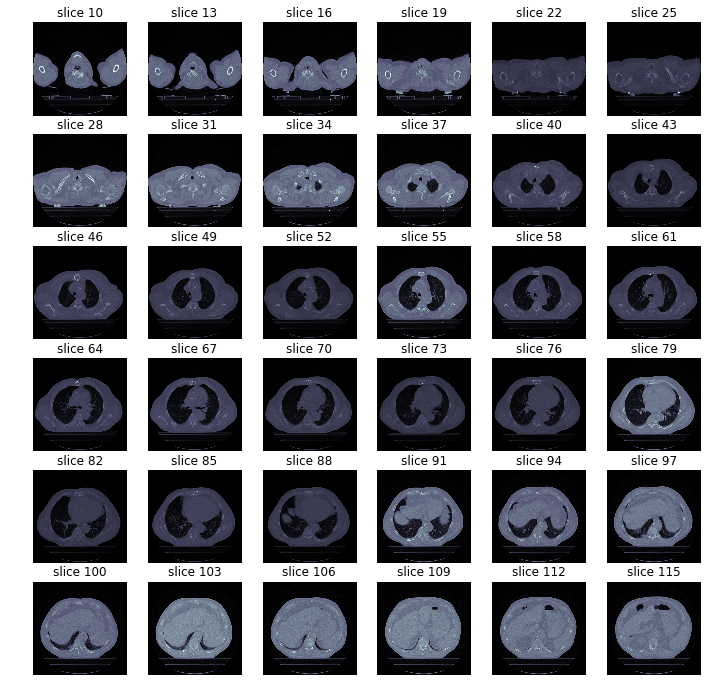

LUNG1-241


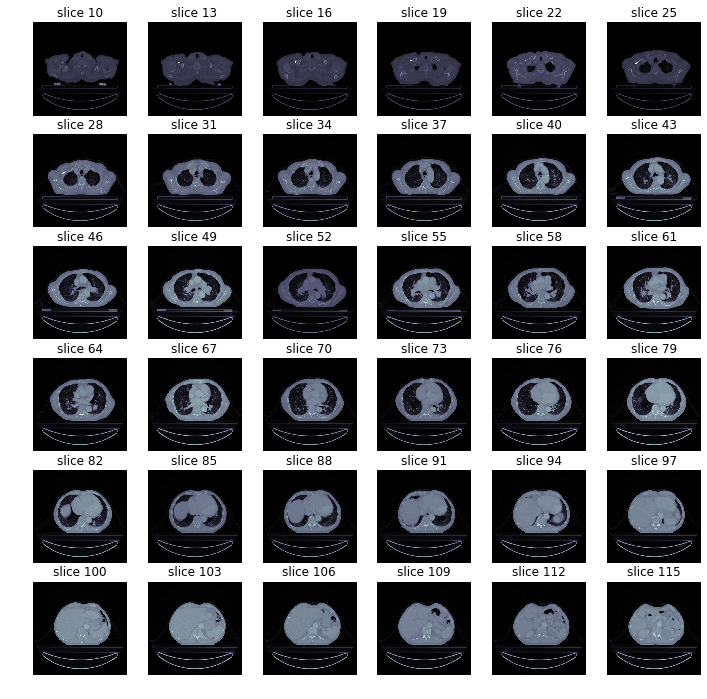

LUNG1-321


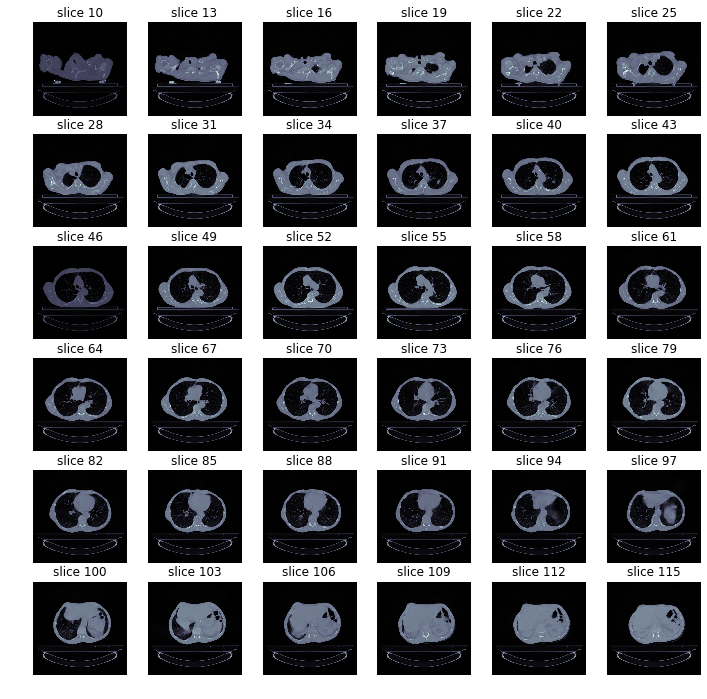

LUNG1-401


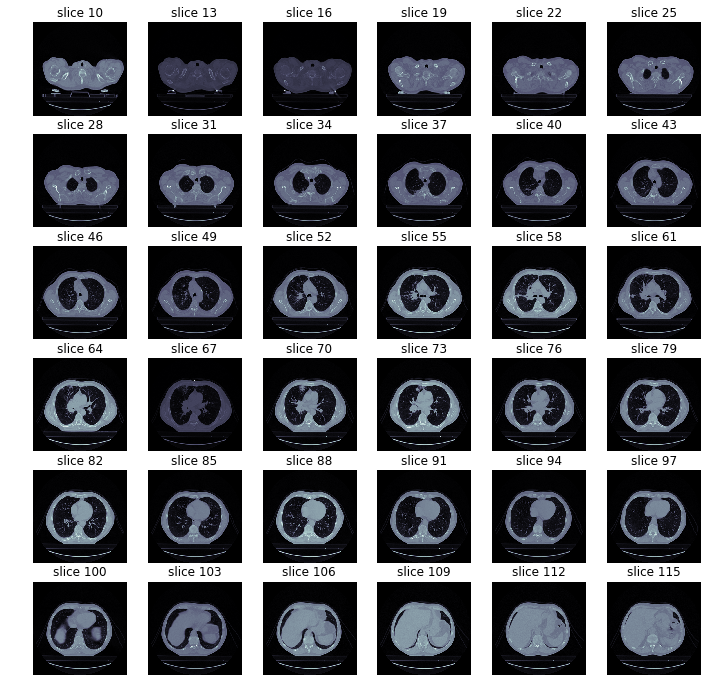

In [61]:
# This is a good chance to visualize the data for these 

for i,stack in enumerate(data):
    print (patients[i*80])
    size = len(stack[0])
    skip = int(np.floor((size-10) / 36))
    plotSlices(stack[0], show_every=skip)

In [154]:
# Now, If we want to use machine learning to identify the tumors in the lungs, 
# we should mask out everything that is not the lungs.
#
#
# How will we do this:
# - First we will standadize the pixel values around 0 by subtracting the mean, and dividing by the standard deviation.
# - Next we will use a k-mean algorythm to seperate the pixels into two populations (soft tissue/bone vs lung/air)
# - Then we will use errosion and dialation to remove some of the smaller features so its easier to find
#   the boundries of the lungs
# - Identify and lable the seperate regions.
# - Seperate the regions into 'Lung' and 'everything else'
# - Create a mask for the lung region.
# - Apply the mask to the ogiginal slice to get rid of everything but the lungs.

# pass the function a pixle map, pmap

def maskLung(pmap, verbose = False):
    # get mean and std to normalize pixels, and some other image properties.
    num_rows = pmap.shape[0]
    num_cols = pmap.shape[1]
    mean = np.mean(pmap)
    std = np.std(pmap)
    
    #normalize
    pmap = (pmap-mean)/std
    
    if verbose:
        print("["+str(num_cols)+","+str(num_rows)+"] pixel array with mean at "+str(mean)+" and std at "+str(std))
        print("")
        print("Image pre-processing")
        plt.imshow(pmap, cmap=plt.cm.bone)
        plt.show()
    
    # get the middle-ish area (near the lung) (we cut out the outside 20%) as a starting guess for our kmean boundry.
    middle = pmap[int(num_cols*0.2):int(num_cols*0.8),int(num_rows*0.2):int(num_rows*0.8)]
    
    # if we had underflow and overflow in our pixel maps, we would want to move those onto our normalized scale now,
    # but as far as I can tell, we dont for these maps.
    
    # Use KMeans to seperate lungs/air vs soft tissue/bone.
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())                             #Identify the centers of the 2 cluster
    threshold = np.mean(centers)                                                    #Define the threshold
    thresh_pmap = np.where(pmap<threshold,1.0,0.0)                                    #Set below thresh to 1.0, and above to 0.0
    
    if verbose:
        print("Centers from KMeans: "+str(centers)+" \nThreshold set at: "+str(threshold))
        print("")
        print("Image post threshold processing:")
        plt.imshow(thresh_pmap, cmap=plt.cm.bone)
        plt.show()
        
    # Now we erode and diolate to remove very small fetures and noise, and diolate so we 
    # include a few pixels around the lung to prevent us from cutting parts of the lung.
    
    eroded = morphology.erosion(thresh_pmap,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    
    if verbose:
        #print("Centers from KMeans: "+str(centers)+" \nThreshold set at: "+str(threshold))
        #print("")
        print("Image post erosion and dilation:")
        plt.imshow(dilation, cmap=plt.cm.bone)
        plt.show()
        
    # Now we want to label the different areas
    labels = measure.label(dilation)              # Each connected area is given its own value
    label_vals = np.unique(labels)                # Returns a list of unique values from labels
    regions = measure.regionprops(labels)         # Measures the properties of the labeled regions
    
    if verbose:
        print("Color map of different regions:")
        plt.imshow(labels) #, cmap=plt.cm.bone)
        plt.show()
        
    
    # Lets figure out which labels go with the lungs
    good_labels = []
    for properties in regions:
        B = properties.bbox          #Returns (y_min,x_min,y_max,x_max)
        min_row = B[0]
        max_row = B[2]
        min_col = B[1]
        max_col = B[3]
        if  ( (max_row-min_row) < (0.9*num_rows) and     # if the rows span less than 90%
              (max_col-min_col) < (0.9*num_cols) and     # and the columns span less than 90%
              (min_row) > (0.2*num_rows) and             # and the rows are inside the middle 60% of the frame
              (max_row) < (0.8*num_rows)
            ):
            good_labels.append(properties.label)         # Then this region must be a good one!
            
            
    # Now we create the mask
    # We also diolate it once more with a larger size, to smooth/fill in the lung mask.
    mask = np.ndarray([num_rows,num_cols],dtype=np.int8)
    mask[:] = 0
    for label in good_labels:
        mask = mask + np.where(labels==label,1,0)
    mask = morphology.dilation(mask,np.ones([10,10]))
    
    if verbose:
        print("Final Lung Mask:")
        plt.imshow(mask, cmap=plt.cm.bone)
        plt.show()
    
    
    # Finally, apply the mask (and output if verbose), renormalize, and set the areas that are cut and set to zero to
    # -std, because they should be near the minimum, not the middle.
    
    new_pmap = pmap*mask
    new_mean = np.mean(new_pmap[mask>0])  #<- is this working?
    new_std = np.std(new_pmap[mask>0])
    
    new_pmap = new_pmap-new_mean
    new_pmap = new_pmap/new_std
    
    
    if verbose:
        print("Final image with mask applied:")
        plt.imshow(new_pmap, cmap=plt.cm.bone)
        plt.show()
    
    return new_pmap
    
    
    
# We also are going to need a way to relate the tumor contours to the actual areas of the slices.  
# To do this we will need to
# - First get the individual contours and slices matched up
# - Next, get them into the same coordinate system 
# - Then third convert into label map

def labelTumor (patient, verbose = False):
    slices = patient[0]
    contours = patient[1][0]
    if (contours == []):
        Print("No contours manually identified")
        return slices
    
    #Define the cordinate system
    
    z = [s.ImagePositionPatient[2] for s in slices]      # array of z positions
    pos_row = slices[0].ImagePositionPatient[1]          # row origin
    spacing_row = slices[0].PixelSpacing[1]              # row spacing
    pos_col = slices[0].ImagePositionPatient[0]          # column origin
    spacing_col = slices[0].PixelSpacing[0]              # column spacing
    
    
    
    image = np.stack([s.pixel_array for s in slices], axis=-1)
    label = np.zeros_like(image, dtype=np.uint8)

    #loop through the sets of contours that represent a tumor
    for i,contour in enumerate(contours.ROIContourSequence):
        
        #Save a lable for the tumor, incase there is more than one.        
        num = contour.ReferencedROINumber
        assert num == contours.StructureSetROISequence[i].ROINumber 
        
        #loop through the contours that are slices of a single tumor
        for con in contour.ContourSequence:
            
            nodes = np.array(con.ContourData).reshape((-1, 3))
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(np.around(nodes[0, 2], 1))
            row = (nodes[:, 1] - pos_row) / spacing_row
            col = (nodes[:, 0] - pos_col) / spacing_col
            rr, cc = polygon(row, col)
            label[rr, cc, z_index] = num
               
    colors = tuple(np.array([con.ROIDisplayColor for con in contours.ROIContourSequence]) / 255.0)
    return label, colors

        
        
    
    

[512,512] pixel array with mean at 245.02707290649414 and std at 397.01538438974524

Image pre-processing


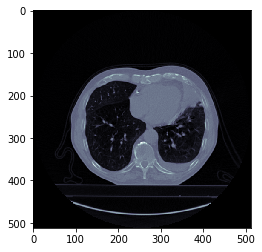

Centers from KMeans: [-0.29342395936491306, 1.9816658111104686] 
Threshold set at: 0.8441209258727778

Image post threshold processing:


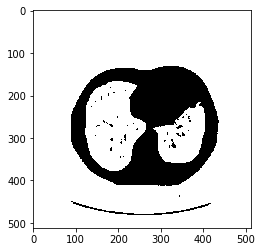

Image post erosion and dilation:


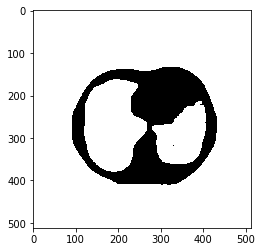

Color map of different regions:


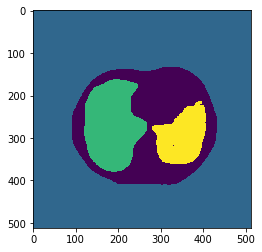

Final Lung Mask:


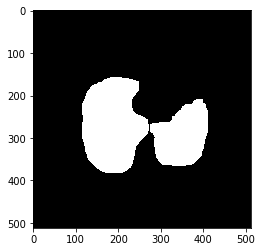

Final image with mask applied:


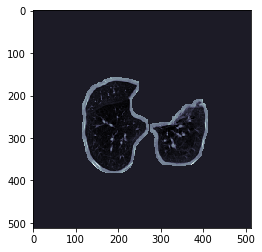

In [155]:
#testing maskLung
newimg=maskLung(data[0][0][81].pixel_array,verbose=True)

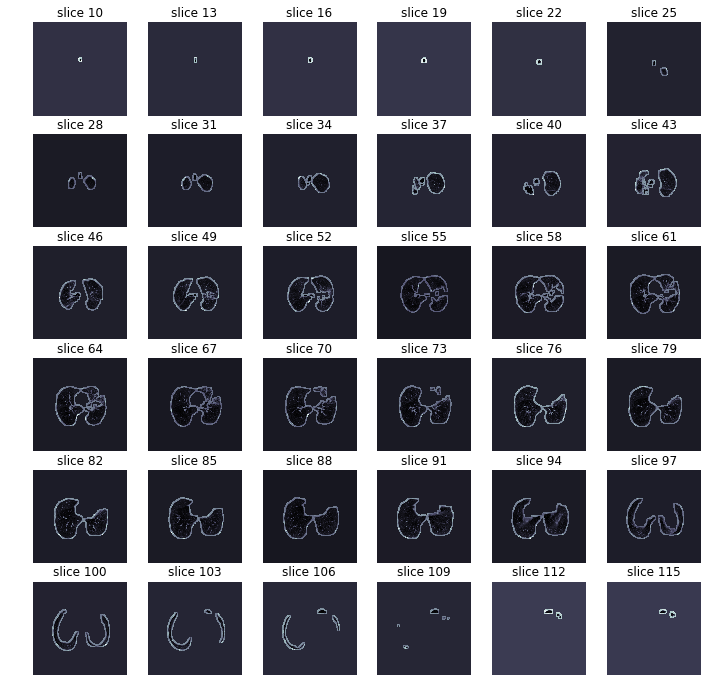

In [151]:
# Great, now lets see how things look with the mask applied to a whole stack.

newSlices = []
for s in data[0][0]:
    newSlices.append(maskLung(s.pixel_array))
    
plotPixelStack(newSlices)

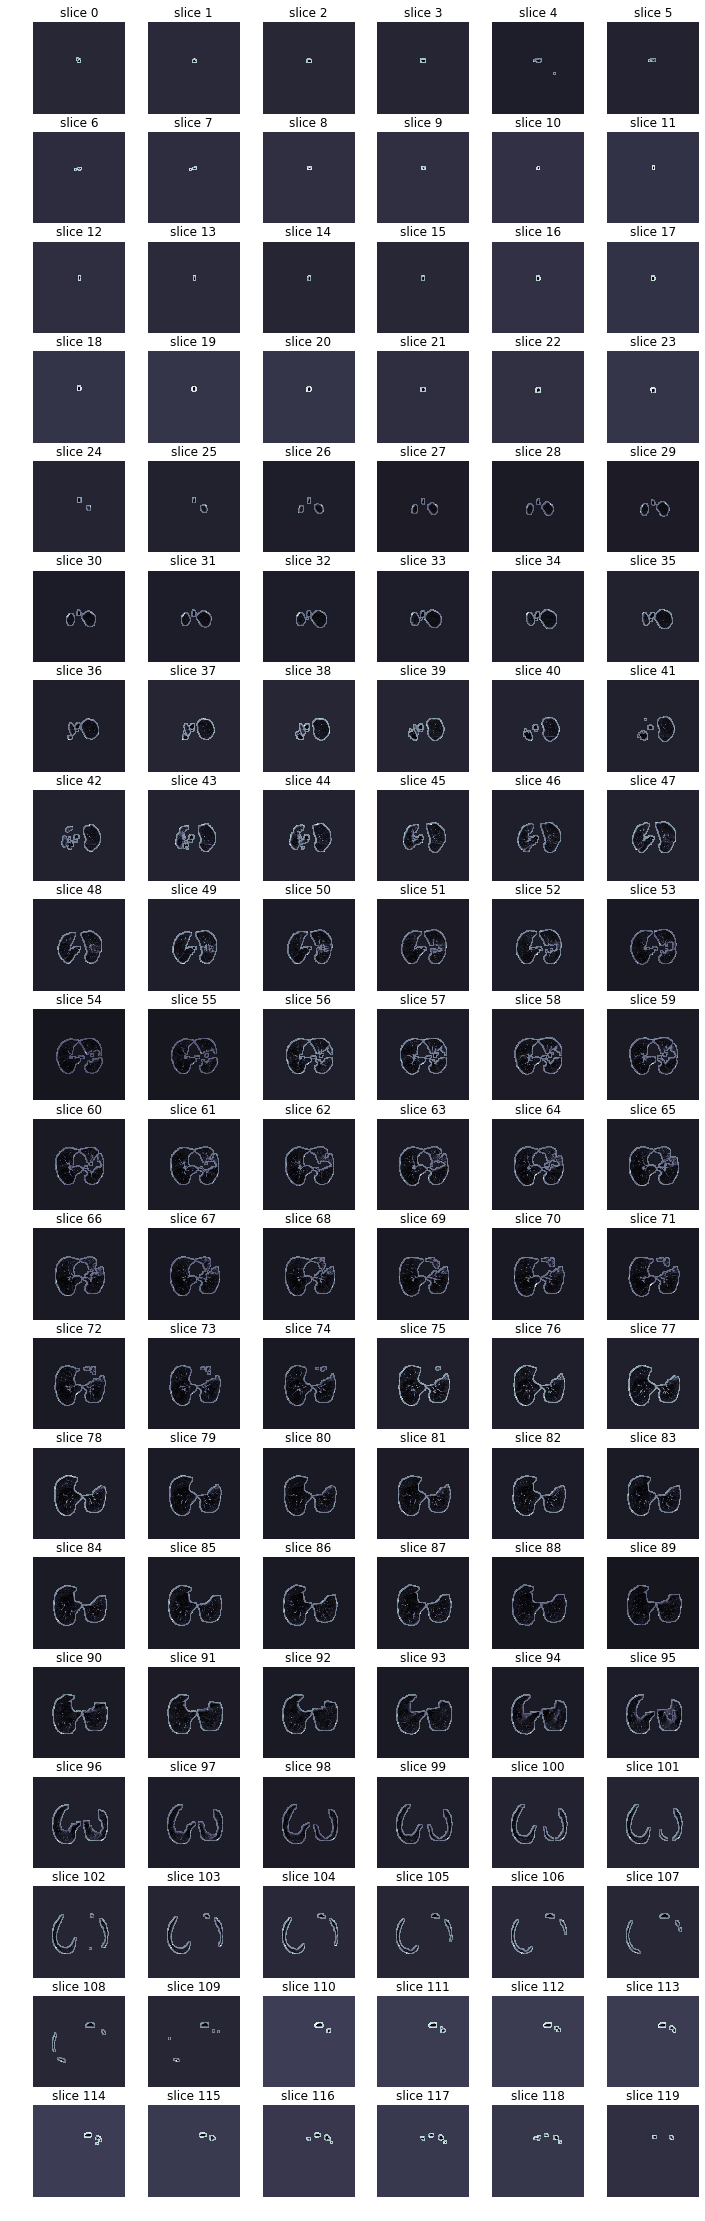

In [152]:
plotPixelStack(newSlices, rows=20, cols=6, start_with=0, show_every=1)

In [50]:
# I am a little worried our new mask is cutting away too much, but for now let us press on!

In [153]:
# Apply the mask to all the patients
mask_data = []
for p in data:
    mask_slices = []
    for s in p[0]:
        mask_slices.append(maskLung(s.pixel_array))
    mask_data.append(mask_slices)

C:\Users\jacob\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jacob\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jacob\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jacob\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jacob\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [119]:
# Test the contour/tumor labeling

tumor,colors = labelTumor(data[0])

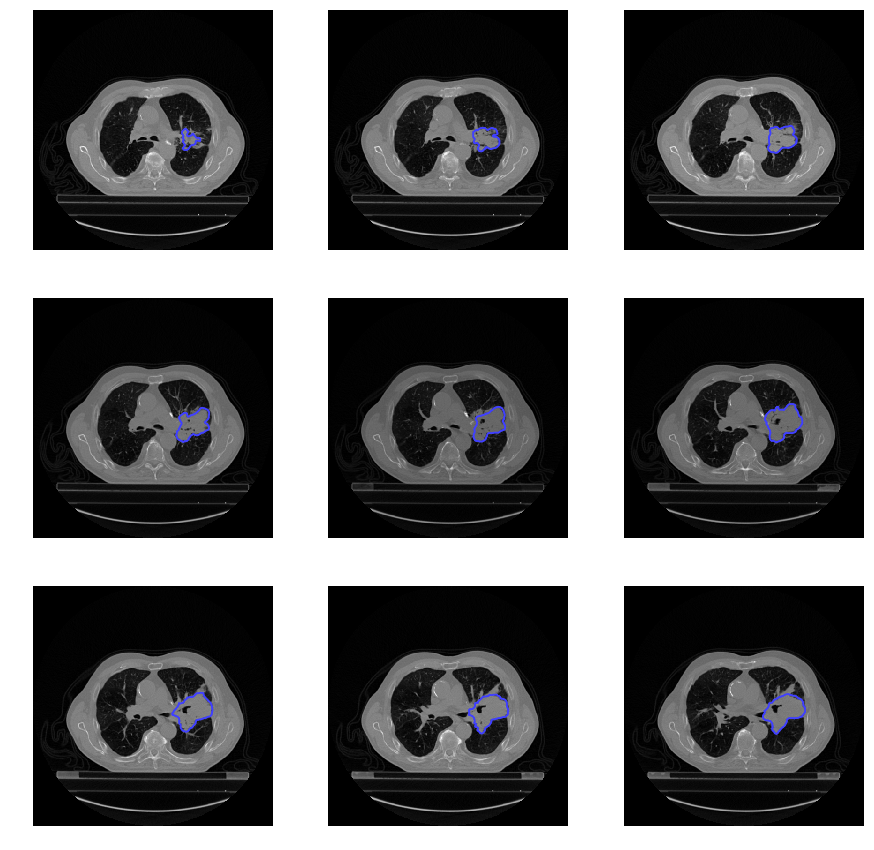

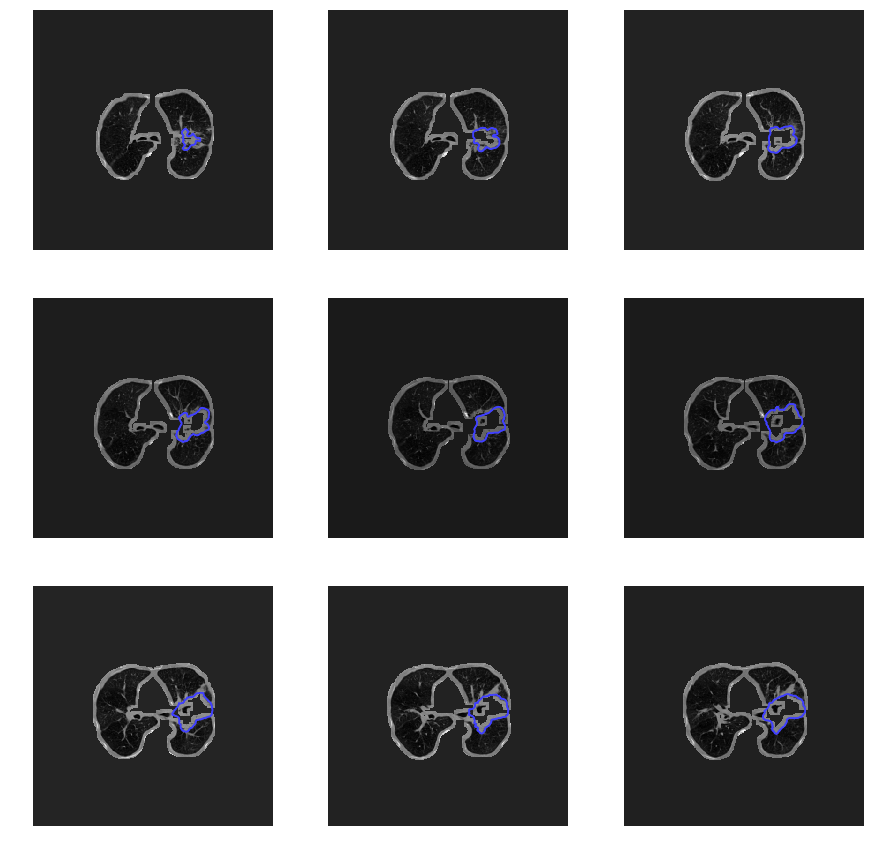

In [120]:
image = np.stack([s.pixel_array for s in data[0][0]], axis=-1)
newImage = np.stack([s for s in newSlices], axis=-1)

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., i + 50], cmap="gray")
    plt.contour(tumor[..., i + 50], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
    plt.axis('off')
plt.show()
    
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(newImage[..., i + 50], cmap="gray")
    plt.contour(tumor[..., i + 50], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
    plt.axis('off')
plt.show()

In [121]:
# So our masking algorthm is cutting out the middle of very large tumors, but leaving the outside.  Interesting. 
# Either way the labeling is definitly working

In [122]:
# Now that we have applied to mask to all of our data, we can do some feature engineering, so our machine learning has
# something to work with.  Following along with several blogs online, I will apply a 3d CNN (convolutional neural network)

In [141]:
np.std(newSlices[0])

0.08958539755263376